In [1]:
%matplotlib widget

# DEFAULTS

In [252]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tqdm import tqdm
from scipy.integrate import simpson
from truncation import get_truncation


FORCES = ["LO", "NLO", "N2LO", "N3LO", "N4LO", "N4LO+"]
CUTOFF = [400, 450, 500, 550]

# plt.style.use(['science', 'retro'])

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'DejaVu Sans'
mpl.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
mpl.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "DejaVu Sans"

plt.rc('text', usetex=True)
# plt.rc('text', usetex=False)
plt.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['lines.linewidth'] = 2

line_styles = {"LO": {"marker": "d", "markevery": 10, "markersize": 3, "color": "tab:cyan"},
               "NLO": {"marker": ".", "markevery": 10, "color": "orange"},
               "N2LO": {"ls":  (0, (5, 3)), "color": "green"},
               "N3LO": {"ls": "dotted", "color": "blue"},
               "N4LO": {"ls": (0, (5, 2, 0.8, 2, 0.8, 2)), "color": "red"},
               "N4LO+": {"color": "black"},
               "AV18": {"ls": (0, (5, 2, 1.3, 2,)), "color": "blueviolet"},
               "SIEGERT": {"color": "blue"},
               "1NC": {"color": "deeppink", "ls": "dashed"},
               "PW": {"ls":  (0, (5, 2, 1.3, 2,)), "color": "green"}
               }
ls_cutoff = {400: line_styles["N4LO"],
             450: line_styles["N4LO+"],
             500: line_styles["N2LO"],
             550: line_styles["N3LO"],
             }

exp_style = [
    {"fmt": "ok"},
    {"fmt": "ok", "markerfacecolor": "None", "markeredgecolor": "k"},
    {"fmt": "sk"},
    {"fmt": "^k"},
    {"fmt": "Xk"},
    {"fmt": "dk"},
]

trunc_colors = {
    "NLO": "bisque",
    "N2LO": "limegreen",
    "N3LO": "dodgerblue",
    "N4LO": "red",
    "N4LO+": "black",
}

marker_common = {"markersize": 6, "elinewidth": 0.9, "capsize": 2.5}


df_my = pd.read_csv("Deuteron/deuteron_all_data.csv")
df_my.T21D2 *= 2
df_my.T22D2 *= 2
df_my.T21D *= 2
df_my.T22D *= 2
df_my.AX *= -1
df_my.AX2 *= -1
df_exp = pd.read_csv("./Deuteron/deuteron_exp_diffcross.csv")
df_exp_tot = pd.read_csv("./Deuteron/deuteron_exp_totcross.csv")

OBSERVABLES = [ob for ob in df_my.columns.values if ob not in [
    "THCM", "angle", "CUTOFF", "FORCE"]]

my_energies = df_my.Energy.unique()
my_energies.sort()

rachek_bins = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/rachek_t2i_vs_theta.txt", delim_whitespace=True,
                          names=["Emin", "Emax", "Emean", "THmin", "THmax", "THmean",
                                 "T20", "T20stater", "T20syser", "T21", "T21stater", "T21syser",
                                 "T22", "T22stater", "T22syser"])


In [253]:
def relative_diff(*args):
    return (max(args) - min(args))/np.mean(args)

In [254]:
print(*OBSERVABLES)

CROSS CROSS2 P1 P2 PHIP WAVE T11D T20D T21D T22D T11D2 T20D2 T21D2 T22D2 AX AY AZ AX2 AY2 AZ2 POLNOUT(y) POLNOUT2(y) CROSSCAP CROSSCAP2 AYN1CAP AYN1CAP2 Energy


# Cross section

## Differential Cross Section

### Horizontal

In [5]:
obs = "CROSS2"
energy = 30
cutoff = 450


In [107]:
df_tmp = df_my[(df_my.CUTOFF == 450) &
               (df_my.Energy == en) &
               # (df_my.FORCE.isin(FORCES[:-1])) &
               (df_my.WAVE == "SIEGERT")]
df_tmp.sort_values("angle", inplace=True)
df_piv = df_tmp.pivot(index="angle", columns="FORCE")[
    "CROSS2"].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, energy, Lambda=650)


0.24737717255256778


/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [121]:
df_tmp = df_my[(df_my.FORCE == "N4LO+") &
               (df_my.Energy == 140) &
               (df_my.WAVE == "SIEGERT")]
df_piv = df_tmp.groupby("angle")["CROSS2"].agg(["min", "max"])
print("Max cutoff diff [%]")
((df_piv["max"]-df_piv["min"])/df_piv["max"]*100).max()

Max cutoff diff [%]


11.707317073170742

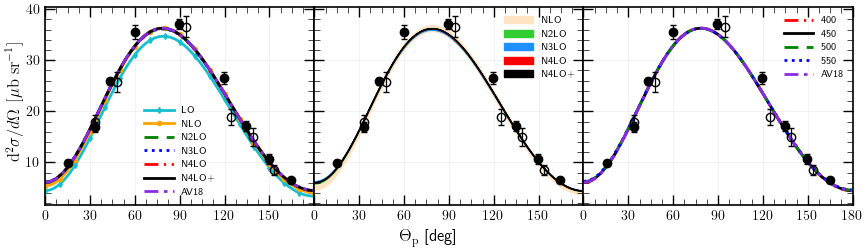

In [108]:
ylabel = "$\mathrm{d}^2\sigma / d \Omega ~[\mu\mathrm{b~sr}^{-1}]$"

# fig, axes = plt.subplots(1,2, figsize=(6.5, 2.8))
fig = plt.figure(figsize=(9, 2.8))
gs = fig.add_gridspec(ncols=3, wspace=0)
axes = gs.subplots(sharey=True)
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.08, size=12)
fig.supylabel(ylabel, x=0.03, y=0.6, size=12)
for force in FORCES:
    df_tmp = df_my[(df_my.FORCE == force) &
                   (df_my.CUTOFF == cutoff) &
                   (df_my.Energy == energy) &
                   (df_my.WAVE == "SIEGERT")]
    axes[0].plot(df_tmp.angle, df_tmp[obs],
                 **line_styles[force], label=force)
    if force != "LO":
        axes[1].fill_between(df_tmp.angle, df_tmp[obs].values+df_trunc[force].values,
                             df_tmp[obs].values-df_trunc[force].values, label=force,
                             color=trunc_colors[force])
    # break
axes[1].legend()
for cut in CUTOFF:
    df_tmp = df_my[(df_my.FORCE == "N4LO+") &
                   (df_my.CUTOFF == cut) &
                   (df_my.Energy == energy) &
                   (df_my.WAVE == "SIEGERT")]
    axes[2].plot(df_tmp.angle, df_tmp[obs],
                 **ls_cutoff[cut], label=cut)
df_av18 = df_my[(df_my.FORCE == "AV18") & (df_my.Energy == energy)]
for j, ax in enumerate(axes):
    if j != 1:
        ax.plot(df_av18.angle, df_av18[obs],
                **line_styles["AV18"], label="AV18")
    for i, fname in enumerate(df_exp[df_exp.energy == energy].fname.unique()):
        df_tmp = df_exp[(df_exp.energy == energy) & (df_exp.fname == fname)]
        ax.errorbar(df_tmp.angle, df_tmp.CROSS,
                    yerr=df_tmp.error, zorder=3, **exp_style[i], **marker_common)
    # style
    ax.legend(fontsize=7, handlelength=3)
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax.set_xticks(np.arange(0, 180+j-1, 30))
    ax.set_xlim([0, 180])
    ax.grid(alpha=0.2)
    ax.set_zorder(-1)
fig.tight_layout()
plt.savefig(f"Figures_De/{obs}_{energy}mev.pdf",
            dpi=600, facecolor="white")
plt.show()


### Vertical

In [48]:
obs = "CROSS2"
energy = [30, 100, 140]
cutoff = 450

In [49]:
df_tmp = df_my[(df_my.CUTOFF == 450) &
               (df_my.Energy.isin(energy)) &
               # (df_my.FORCE.isin(FORCES[:-1])) &
               (df_my.WAVE == "SIEGERT")]
df_tmp.sort_values("angle", inplace=True)
df_trunc = {}
for en in energy:
    df_piv = df_tmp[df_tmp.Energy == en].pivot(index="angle", columns="FORCE")[
        "CROSS2"].reindex(FORCES, axis=1)
    df_trunc[en] = get_truncation(df_piv, en, Lambda=650)


/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


#### Order 

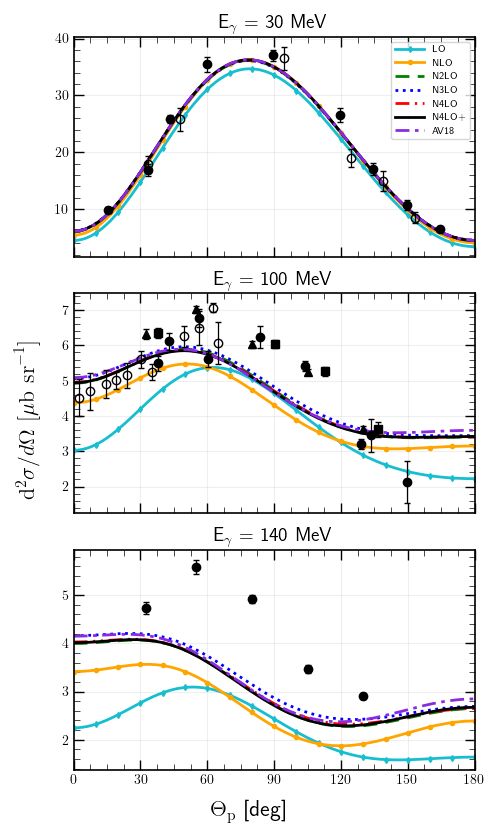

In [251]:
ylabel = "$\mathrm{d}^2\sigma / d \Omega ~[\mu\mathrm{b~sr}^{-1}]$"

# fig, axes = plt.subplots(1,2, figsize=(6.5, 2.8))
fig = plt.figure(figsize=(5, 8.4))
gs = fig.add_gridspec(nrows=3)
ax = gs.subplots(sharex=True)
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.02, size=16)
fig.supylabel(ylabel, x=0.03, size=16)
for j, en in enumerate(energy):
    for force in FORCES:
        df_tmp = df_my[(df_my.FORCE == force) &
                    (df_my.CUTOFF == cutoff) &
                    (df_my.Energy == en) &
                    (df_my.WAVE == "SIEGERT")]
        ax[j].plot(df_tmp.angle, df_tmp[obs],
                    **line_styles[force], label=force)
    df_av18 = df_my[(df_my.FORCE == "AV18") & (df_my.Energy == en)]
    ax[j].plot(df_av18.angle, df_av18[obs],
            **line_styles["AV18"], label="AV18")
    for i, fname in enumerate(df_exp[df_exp.energy == en].fname.unique()):
        df_tmp = df_exp[(df_exp.energy == en) & (df_exp.fname == fname)]
        ax[j].errorbar(df_tmp.angle, df_tmp.CROSS,
                    yerr=df_tmp.error, zorder=3, **exp_style[i], **marker_common)
    # style
    ax[j].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax[j].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax[j].tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax[j].tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax[j].set_xticks(np.arange(0, 180+j-1, 30))
    ax[j].set_xlim([0, 180])
    ax[j].grid(alpha=0.2)
    ax[j].set_zorder(-1)
    ax[j].set_title(f"E$_\gamma$ = {en} MeV", size=14)
ax[0].legend(fontsize=7, handlelength=3)
fig.tight_layout()
fig.savefig(f"Figures_De/{obs}_order_vert.pdf",
            dpi=600, facecolor="white")
plt.show()


##### difference $N^4LO$ and $N^4LO+$

In [166]:
df_tmp = df_my[(df_my.FORCE.isin(["N4LO", "N4LO+"])) &
                (df_my.CUTOFF == 450) &
                (df_my.Energy == 100) &
                (df_my.WAVE == "SIEGERT")]

In [167]:
reldif = df_tmp.pivot(index="angle", columns="FORCE")["CROSS2"].apply(lambda x: relative_diff(*x), axis=1)*100

In [168]:
reldif.sort_values(ascending=False)[:5]
# reldif.iloc[80]

angle
107.0    0.791883
115.0    0.788436
106.0    0.785469
109.0    0.779580
113.0    0.777403
           ...   
0.0      0.181984
1.0      0.181947
3.0      0.181690
4.0      0.181433
5.0      0.181141
Length: 117, dtype: float64

In [137]:
df_tmp.pivot(index="angle", columns="FORCE")["CROSS2"].diff(axis=1).iloc[80]

FORCE
N4LO       NaN
N4LO+   -0.025
Name: 80.0, dtype: float64

##### difference $N^4LO+$ and $AV18$

In [159]:
df_tmp = df_my[(df_my.FORCE.isin(["AV18", "N4LO+"])) &
                (df_my.CUTOFF.isin([0, 450])) &
                (df_my.Energy == 140) &
                (df_my.WAVE == "SIEGERT")]

In [160]:
reldif = df_tmp.pivot(index="angle", columns="FORCE")["CROSS2"].apply(lambda x: relative_diff(*x), axis=1)*100

In [163]:
reldif.sort_values(ascending=False).iloc[80]

3.090400292006321

In [164]:
df_tmp.pivot(index="angle", columns="FORCE")["CROSS2"].diff(axis=1).iloc[80]

FORCE
AV18       NaN
N4LO+   -0.034
Name: 80.0, dtype: float64

##### difference with exp

In [107]:
df_tmp = df_my[(df_my.FORCE =="N4LO+") &
                (df_my.CUTOFF == 450) &
                (df_my.Energy == 140) &
                (df_my.WAVE == "SIEGERT")]

In [108]:
df_exp_tmp = df_exp[df_exp.energy == 140]

In [109]:
df_exp_tmp["angle"] = df_exp_tmp["angle"].astype("int")

/tmp/ipykernel_891407/2503728775.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp_tmp["angle"] = df_exp_tmp["angle"].astype("int")


In [110]:
df_merged = pd.merge(df_tmp[["angle", "CROSS2"]], df_exp_tmp[["angle", "CROSS"]], on="angle")

In [111]:
(df_merged[["CROSS2", "CROSS"]].apply(lambda x: relative_diff(*x), axis=1)*100).max()

48.64181933038534

In [112]:
(df_merged["CROSS2"] - df_merged["CROSS"]).abs().max()

1.9249999999999998

#### Cutoff

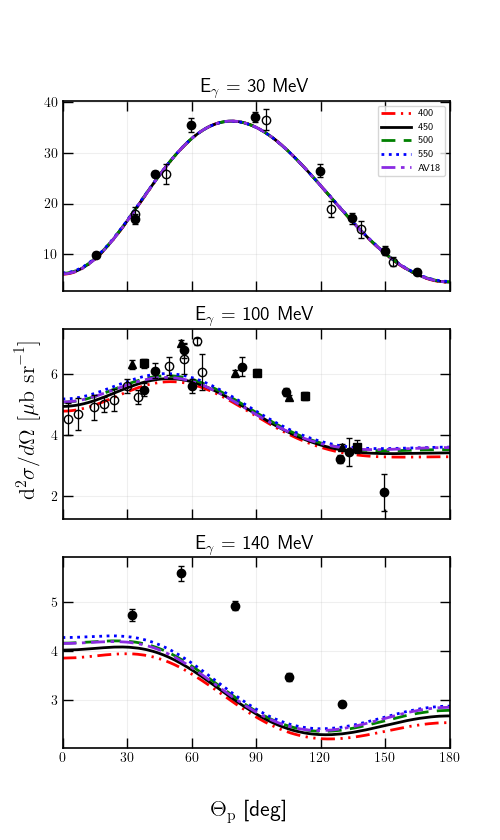

In [169]:
ylabel = "$\mathrm{d}^2\sigma / d \Omega ~[\mu\mathrm{b~sr}^{-1}]$"

# fig, axes = plt.subplots(1,2, figsize=(6.5, 2.8))
fig = plt.figure(figsize=(5, 8.4))
gs = fig.add_gridspec(nrows=3)
ax = gs.subplots(sharex=True)
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.02, size=16)
fig.supylabel(ylabel, x=0.03, size=16)
for j, en in enumerate(energy):
    df_av18 = df_my[(df_my.FORCE == "AV18") & (df_my.Energy == en)]
    for cut in CUTOFF:
        df_tmp = df_my[(df_my.FORCE == "N4LO+") &
                    (df_my.CUTOFF == cut) &
                    (df_my.Energy == en) &
                    (df_my.WAVE == "SIEGERT")]
        ax[j].plot(df_tmp.angle, df_tmp[obs],
                    **ls_cutoff[cut], label=cut)
    df_av18 = df_my[(df_my.FORCE == "AV18") & (df_my.Energy == en)]
    ax[j].plot(df_av18.angle, df_av18[obs],
            **line_styles["AV18"], label="AV18")
    for i, fname in enumerate(df_exp[df_exp.energy == en].fname.unique()):
        df_tmp = df_exp[(df_exp.energy == en) & (df_exp.fname == fname)]
        ax[j].errorbar(df_tmp.angle, df_tmp.CROSS,
                    yerr=df_tmp.error, zorder=3, **exp_style[i], **marker_common)
    # style
    ax[j].tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax[j].tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax[j].set_xticks(np.arange(0, 180+j-1, 30))
    ax[j].set_xlim([0, 180])
    ax[j].grid(alpha=0.2)
    ax[j].set_zorder(-1)
    ax[j].set_title(f"E$_\gamma$ = {en} MeV", size=14)
ax[0].legend(fontsize=7, handlelength=3)
# fig.tight_layout()
# plt.savefig(f"Figures_De/{obs}_cutoff_vert.pdf",
#             dpi=600, facecolor="white")
plt.show()


#### Truncation

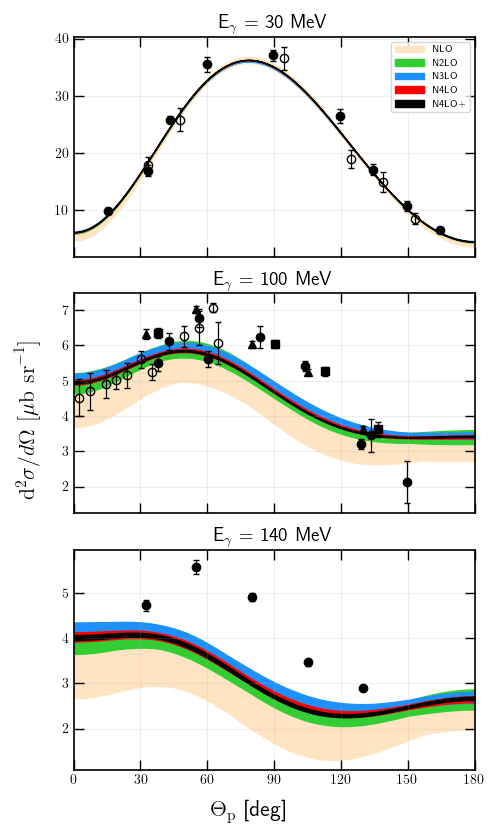

In [170]:
ylabel = "$\mathrm{d}^2\sigma / d \Omega ~[\mu\mathrm{b~sr}^{-1}]$"

# fig, axes = plt.subplots(1,2, figsize=(6.5, 2.8))
fig = plt.figure(figsize=(5, 8.4))
gs = fig.add_gridspec(nrows=3)
ax = gs.subplots(sharex=True)
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.02, size=16)
fig.supylabel(ylabel, x=0.03, size=16)
for j, en in enumerate(energy):
    for force in FORCES:
        df_tmp = df_my[(df_my.FORCE == force) &
                    (df_my.CUTOFF == cutoff) &
                    (df_my.Energy == en) &
                    (df_my.WAVE == "SIEGERT")]
        if force != "LO":
            ax[j].fill_between(df_tmp.angle, df_tmp[obs].values+df_trunc[en][force].values,
                                df_tmp[obs].values-df_trunc[en][force].values, label=force,
                                color=trunc_colors[force])

    for i, fname in enumerate(df_exp[df_exp.energy == en].fname.unique()):
        df_tmp = df_exp[(df_exp.energy == en) & (df_exp.fname == fname)]
        ax[j].errorbar(df_tmp.angle, df_tmp.CROSS,
                    yerr=df_tmp.error, zorder=3, **exp_style[i], **marker_common)
    # style
    ax[j].tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax[j].tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax[j].set_xticks(np.arange(0, 180+j-1, 30))
    ax[j].set_xlim([0, 180])
    ax[j].grid(alpha=0.2)
    ax[j].set_zorder(-1)
    ax[j].set_title(f"E$_\gamma$ = {en} MeV", size=14)
ax[0].legend(fontsize=7, handlelength=3)
fig.tight_layout()
# plt.savefig(f"Figures_De/{obs}_truncation_vert.pdf",
#             dpi=600, facecolor="white")
plt.show()

In [64]:
df_tmp = df_my[(df_my.FORCE == "N4LO+") &
                    (df_my.CUTOFF == 450) &
                    (df_my.Energy == 140) &
                    (df_my.WAVE == "SIEGERT")][["angle", "CROSS2"]]

In [65]:
df_tmp["CROSS+"] = df_tmp["CROSS2"] + df_trunc[100]["N4LO+"].values
df_tmp["CROSS-"] = df_tmp["CROSS2"] - df_trunc[100]["N4LO+"].values

In [66]:
df_tmp[["CROSS+", "CROSS-"]].diff(axis=1).iloc[80]

CROSS+         NaN
CROSS-   -0.043817
Name: 17094, dtype: float64

In [67]:
reldif = df_tmp[["CROSS+", "CROSS-"]].apply(lambda x: relative_diff(*x), axis=1)*100

In [68]:
reldif.iloc[80]


1.4629895082876083

In [73]:
df_tmp = df_my[(df_my.FORCE == "N4LO+") &
                    (df_my.Energy == 140) &
                    (df_my.WAVE == "SIEGERT")]
reldif2 = df_tmp.pivot(index="angle", columns="CUTOFF")["CROSS2"].apply(lambda x: relative_diff(*x), axis=1)*100

In [74]:
reldif2.iloc[80]

5.661782964986337

#### PW, 1NC

In [4]:
df_tmp = df_my[(df_my.FORCE == "N4LO+") &
                    (df_my.CUTOFF == 450) &
                    # (df_my.Energy == 100) &
                    (df_my.WAVE.isin(["1NC", "SIEGERT"]))]

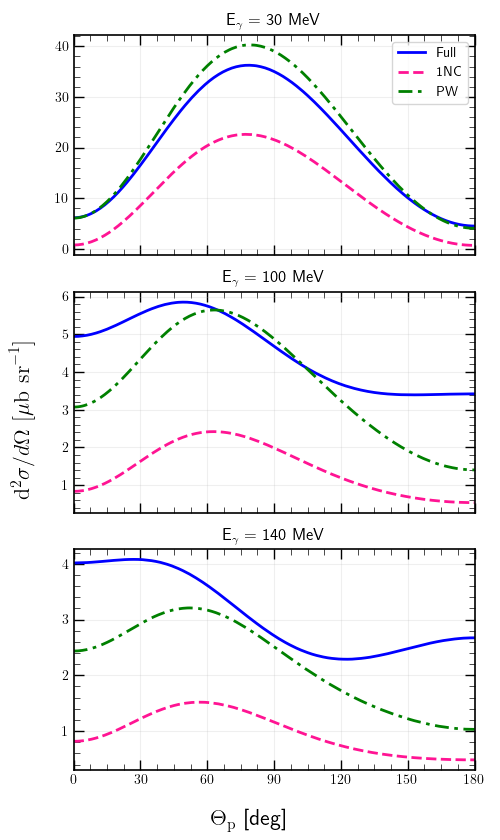

In [247]:
# fig, ax = plt.subplots(1, 3, figsize=(9, 2.8), constrained_layout=True)
fig = plt.figure(figsize=(5, 8.4))
gs = fig.add_gridspec(nrows=3)
ax = gs.subplots(sharex=True)
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", size=16)
fig.supylabel("$\mathrm{d}^2\sigma / d \Omega ~[\mu\mathrm{b~sr}^{-1}]$", size=16)
for i, en in enumerate([30, 100, 140]):
    ax[i].plot(df_tmp[(df_tmp.WAVE == "SIEGERT") & (df_tmp.Energy == en)].angle,
               df_tmp[(df_tmp.WAVE == "SIEGERT") & (df_tmp.Energy == en)].CROSS2,
               **line_styles["SIEGERT"], label="Full")
    ax[i].plot(df_tmp[(df_tmp.WAVE == "1NC") & (df_tmp.Energy == en)].angle,
               df_tmp[(df_tmp.WAVE == "1NC") & (df_tmp.Energy == en)].CROSS2,
               **line_styles["1NC"], label="1NC")
    # ax[i].plot(df_tmp[(df_tmp.WAVE == "1NC") & (df_tmp.Energy == en)].angle, df_tmp[(df_tmp.WAVE == "1NC") & (df_tmp.Energy == en)].CROSS)
    ax[i].plot(df_tmp[(df_tmp.WAVE == "SIEGERT") & (df_tmp.Energy == en)].angle,
               df_tmp[(df_tmp.WAVE == "SIEGERT") & (df_tmp.Energy == en)].CROSS,
               **line_styles["PW"], label="PW")

    ax[i].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax[i].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax[i].tick_params(which='minor', direction='in', length=4,
                    width=0.5, top=True, right=True)
    ax[i].tick_params(which='major', direction='in',
                length=7, width=1, top=True, right=True, zorder=1)
    ax[i].set_xticks(np.arange(0, 180+j-1, 30))
    ax[i].set_xlim([0, 180])

    ax[i].set_title("E$_\gamma$ = {} MeV".format(en))
    ax[i].set_xticks(np.arange(0, 180+j-1, 30))
    ax[i].set_xlim([0, 180])
    ax[i].grid(alpha=0.2)
    ax[i].set_zorder(-1)
ax[0].legend()
# plt.setp(ax, xticks=np.arange(6), xticklabels=FORCES)

plt.tight_layout()

plt.savefig(f"Figures_De/Diff_cross_pw_1nc.pdf",
            dpi=600, facecolor="white")
plt.show()

In [24]:
(df_tmp[(df_tmp.Energy == 140) & (df_tmp.WAVE == "SIEGERT")][[
    "CROSS", "CROSS2"]].apply(lambda x: relative_diff(*x), axis=1)*100).iloc[80]


7.1947423037011475

In [28]:
df_tmp[(df_tmp.Energy == 140) & (df_tmp.WAVE == "SIEGERT")][[
    "CROSS", "CROSS2"]].diff(axis=1).iloc[80]


CROSS       NaN
CROSS2    0.208
Name: 17094, dtype: float64

In [39]:
(df_tmp[df_tmp.Energy == 140].pivot(index="angle", columns="WAVE")["CROSS2"].apply(lambda x: relative_diff(*x), axis=1)*100).iloc[80]


77.82931354359927

In [44]:
df_tmp[df_tmp.Energy == 140].pivot(index="angle", columns="WAVE")["CROSS2"].diff(axis=1).iloc[80]

WAVE
1NC          NaN
SIEGERT    1.678
Name: 80.0, dtype: float64

## Total Cross Section

### plot

In [10]:
df_tmp = df_my[(df_my.FORCE == "N4LO+") &
               (df_my.CUTOFF == 450) &
               (df_my.WAVE == "SIEGERT")]


In [11]:
df_tmp = df_my[(df_my.FORCE == "N4LO+") &
               (df_my.CUTOFF == 450) &
               (df_my.WAVE == "SIEGERT")]
df_piv = pd.pivot(df_tmp, index="THCM", columns="Energy")["CROSS2"]
CROSS_TOT = 2*np.pi*simpson(df_piv, x=df_piv.index.values, axis=0)
df_tmp = df_my[(df_my.FORCE == "N4LO+") &
               (df_my.CUTOFF == 450) &
               (df_my.WAVE == "1NC")]
df_piv = pd.pivot(df_tmp, index="THCM", columns="Energy")["CROSS2"]
CROSS_TOT_1nc = 2*np.pi*simpson(df_piv, x=df_piv.index.values, axis=0)


In [12]:
df_exp_tot.fillna(0, inplace=True)


Bernabei  ->  {'fmt': 'ok'}
Bosman  ->  {'fmt': 'ok', 'markerfacecolor': 'None', 'markeredgecolor': 'k'}
arends  ->  {'fmt': 'sk'}
Skopik  ->  {'fmt': '^k'}
Moreh  ->  {'fmt': 'Xk'}
Birenbaum  ->  {'fmt': 'dk'}


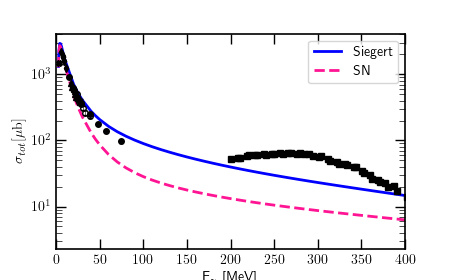

In [13]:
plt.figure(figsize=(4.5, 2.8))
# plt.figure(figsize=(6,4))
# plt.figure(figsize=(6.5, 2.8))
plt.plot(my_energies, CROSS_TOT, label="Siegert", **line_styles["SIEGERT"])
plt.plot(my_energies, CROSS_TOT_1nc, label="SN", **line_styles["1NC"])
marker_common_tmp = {"markersize": 4, "elinewidth": 0.4, "capsize": 1.5}
for i, fname in enumerate(df_exp_tot.fname.unique()):
    df_tmp = df_exp_tot[df_exp_tot.fname == fname]
    plt.errorbar(df_tmp.E, df_tmp.TOTCROSS, yerr=df_tmp.ERR,
                 #  label=fname.split(".")[0].replace("data_arends1984", "arends"),
                 **exp_style[i], **marker_common_tmp)
    print(fname.split(".")[0].replace(
        "data_arends1984", "arends"), " -> ", exp_style[i])
# plt.legend(fontsize=7, handlelength=3)
plt.tick_params(which='minor', direction='in', length=4,
                width=0.5, top=True, right=True)
plt.tick_params(which='major', direction='in',
                length=7, width=1, top=True, right=True)

plt.yscale("log")
# plt.xscale("log")
plt.ylabel("$\sigma_{tot}[\mu \mathrm{b}]$")
plt.xlabel("E$_\gamma$ [MeV]")
plt.legend()


plt.xlim([0, 400])
# plt.ylim([5,3000])
# plt.grid(which='both', alpha=0.5)
# plt.savefig(f"Figures_De/TOTAL_CROSSSECTION.pdf",
#             dpi=600, facecolor="white")
plt.show()


In [46]:
plt.close('all')


Bernabei  ->  {'fmt': 'ok'}
Bosman  ->  {'fmt': 'ok', 'markerfacecolor': 'None', 'markeredgecolor': 'k'}
arends  ->  {'fmt': 'sk'}
Skopik  ->  {'fmt': '^k'}
Moreh  ->  {'fmt': 'Xk'}
Birenbaum  ->  {'fmt': 'dk'}


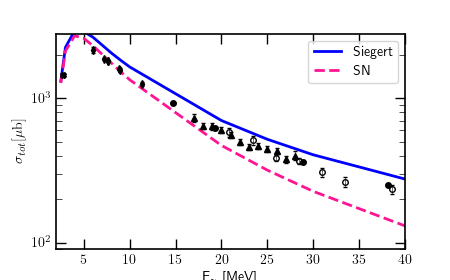

In [14]:
plt.figure(figsize=(4.5, 2.8))
# plt.figure(figsize=(6,4))
# plt.figure(figsize=(6.5, 2.8))
plt.plot(my_energies, CROSS_TOT, label="Siegert", **line_styles["SIEGERT"])
plt.plot(my_energies, CROSS_TOT_1nc, label="SN", **line_styles["1NC"])
marker_common_tmp = {"markersize": 4, "elinewidth": 0.4, "capsize": 1.5}
for i, fname in enumerate(df_exp_tot.fname.unique()):
    df_tmp = df_exp_tot[df_exp_tot.fname == fname]
    plt.errorbar(df_tmp.E, df_tmp.TOTCROSS, yerr=df_tmp.ERR,
                 #  label=fname.split(".")[0].replace("data_arends1984", "arends"),
                 **exp_style[i], **marker_common_tmp)
    print(fname.split(".")[0].replace(
        "data_arends1984", "arends"), " -> ", exp_style[i])
# plt.legend(fontsize=7, handlelength=3)
plt.tick_params(which='minor', direction='in', length=4,
                width=0.5, top=True, right=True)
plt.tick_params(which='major', direction='in',
                length=7, width=1, top=True, right=True)

plt.yscale("log")
# plt.xscale("log")
plt.ylabel("$\sigma_{tot}[\mu \mathrm{b}]$")
plt.xlabel("E$_\gamma$ [MeV]")
plt.legend()


plt.xlim([2, 40])
plt.ylim([90, 2800])
# plt.grid(which='both', alpha=0.5)
# plt.savefig(f"Figures_De/TOTAL_CROSSSECTION_SMALL_REGION.pdf",
#             dpi=600, facecolor="white")
plt.show()


In [19]:
for energy in [5, 10, 20]:
    print(energy, "MeV ->", CROSS_TOT[my_energies ==
          energy], CROSS_TOT_1nc[my_energies == energy])
    print("Difference", CROSS_TOT[my_energies ==
          energy] - CROSS_TOT_1nc[my_energies == energy])
    print("Ratio", CROSS_TOT_1nc[my_energies == energy]/CROSS_TOT[my_energies ==
          energy])
    print("Ratio2", relative_diff(CROSS_TOT_1nc[my_energies == energy], CROSS_TOT[my_energies == energy]))


5 MeV -> [2891.2352231] [2593.69941587]
Difference [297.53580724]
Ratio [0.89709042]
Ratio2 [0.10849202]
10 MeV -> [1646.21977697] [1341.94258388]
Difference [304.27719309]
Ratio [0.81516612]
Ratio2 [0.20365506]
20 MeV -> [700.2247263] [470.72262869]
Difference [229.5020976]
Ratio [0.67224508]
Ratio2 [0.39199388]


In [ ]:
my_energies, CROSS_TOT
my_energies, CROSS_TOT_1nc

### Truncation

In [4]:
df = pd.DataFrame(columns=FORCES)
for en in [30, 100, 140]:
    df_tmp = df_my[(df_my.CUTOFF == 450) &
                (df_my.Energy == en) &
                (df_my.WAVE == "SIEGERT")]

    df_piv = df_tmp.pivot(index="angle", columns="FORCE")[
        "CROSS2"].reindex(FORCES, axis=1)

    df.loc[en] = simpson(df_piv, 2*np.pi*df_piv.index.values, axis=0)
    df_trunc = get_truncation(df, en)
    

In [5]:
df_trunc.set_index(df.index, inplace=True)

In [9]:
df.loc[30]/1000

LO       21.619033
NLO      22.926880
N2LO     23.132893
N3LO     23.178861
N4LO     23.201734
N4LO+    23.230373
Name: 30, dtype: float64

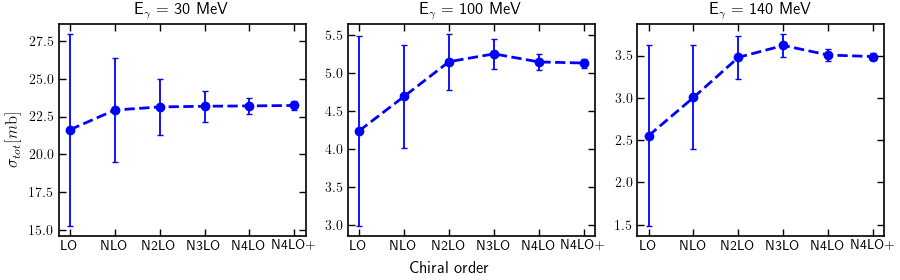

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(9, 2.8), constrained_layout=True)
fig.supxlabel("Chiral order", size=12)
fig.supylabel("$\sigma_{tot}[m \mathrm{b}]$", size=12)
for i, en in enumerate([30, 100, 140]):
    ax[i].errorbar(np.arange(6), df.loc[en]/1000, yerr=df_trunc.loc[en]/1000,
                   fmt="o--", color="blue", markersize=6, elinewidth=1.3, capsize=2.5)

    ax[i].tick_params(axis="y", which='minor', direction='in', length=4,
                      width=0.5, top=True, right=True)
    ax[i].tick_params(axis='x', which='minor', bottom=False)
    ax[i].tick_params(which='major', direction='in',
                      length=5, width=1, top=True, right=True)

    ax[i].set_title("E$_\gamma$ = {} MeV".format(en))
plt.setp(ax, xticks=np.arange(6), xticklabels=FORCES)

plt.savefig(f"Figures_De/TOTAL_CROSSSECTION_Truncation.pdf",
            dpi=600, facecolor="white")
plt.show()


### CUTOFF

In [13]:
df = pd.DataFrame(columns=CUTOFF)
for en in [30, 100, 140]:
    df_tmp = df_my[(df_my.FORCE == "N4LO+") &
                (df_my.Energy == en) &
                (df_my.WAVE == "SIEGERT")]

    df_piv = df_tmp.pivot(index="angle", columns="CUTOFF")[
        "CROSS2"].reindex(CUTOFF, axis=1)

    df.loc[en] = simpson(df_piv, 2*np.pi*df_piv.index.values, axis=0)
    # df_trunc = get_truncation(df, en)
    

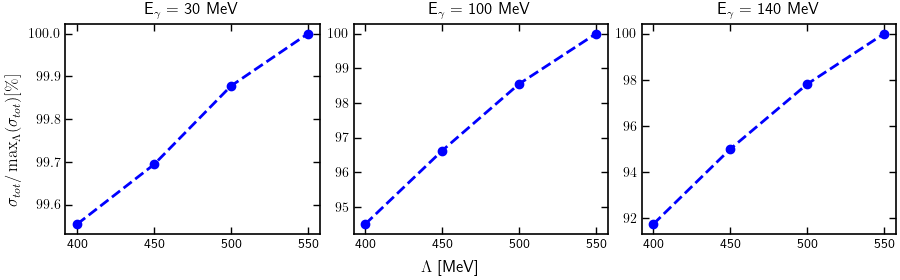

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(9, 2.8), constrained_layout=True)
fig.supxlabel("$\Lambda$ [MeV]", size=12)
# fig.supylabel("$\sigma_{tot}[\mu \mathrm{b}]$", size=12)
fig.supylabel("$\sigma_{tot} / \max_\Lambda(\sigma_{tot})[\%]$", size=12)
# fig.supylabel("$\sigma_{tot} / \sigma_{tot, \Lambda=550}[\%]$", size=12)
for i, en in enumerate([30, 100, 140]):
    ax[i].plot(np.arange(4), df.loc[en]/df.loc[en].max()*100, "--o",  color="blue", markersize=6)

    ax[i].tick_params(axis="y", which='minor', direction='in', length=4,
                      width=0.5, top=True, right=True)
    ax[i].tick_params(axis='x', which='minor', bottom=False)
    ax[i].tick_params(which='major', direction='in',
                      length=5, width=1, top=True, right=True)

    ax[i].set_title("E$_\gamma$ = {} MeV".format(en))
    # ax[i].set_xlim([-0.2, 3.2])
plt.setp(ax, xticks=np.arange(4), xticklabels=CUTOFF)

plt.savefig(f"Figures_De/TOTAL_CROSSSECTION_cutoff.pdf",
            dpi=600, facecolor="white")
plt.show()


# Cross-like

In [269]:
def make_fig(obs, energy, cutoff, df, exp=None, wave="SIEGERT", ylabel=None, save=True):
    df_tmp = df[(df.CUTOFF == cutoff) &
               (df.Energy == energy) &
               (df.WAVE == wave)]
    df_tmp.sort_values("angle", inplace=True)
    df_piv = df_tmp.pivot(index="angle", columns="FORCE")[obs].reindex(FORCES, axis=1)
    df_trunc = get_truncation(df_piv, energy)

    fig = plt.figure(figsize=(5, 8.4))
    gs = fig.add_gridspec(nrows=3, hspace=0)
    axes = gs.subplots(sharex=True)
    fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.02, size=16)
    if not ylabel:
        ylabel = obs
    fig.supylabel(ylabel, x=0.03, size=16)
    for force in FORCES:
        df_tmp = df[(df.FORCE == force) &
                    (df.CUTOFF == cutoff) &
                    (df.Energy == energy) &
                    (df.WAVE == "SIEGERT")]
        axes[0].plot(df_tmp.angle, df_tmp[obs],
                    **line_styles[force], label=force)
        if force != "LO":
            axes[1].fill_between(df_tmp.angle, df_tmp[obs].values+df_trunc[force].values,
                                df_tmp[obs].values-df_trunc[force].values, label=force,
                                color=trunc_colors[force])
        # break
    for cut in CUTOFF:
        df_tmp = df[(df.FORCE == "N4LO+") &
                    (df.CUTOFF == cut) &
                    (df.Energy == energy) &
                    (df.WAVE == "SIEGERT")]
        axes[2].plot(df_tmp.angle, df_tmp[obs],
                    **ls_cutoff[cut], label=cut)
    df_av18 = df[(df.FORCE == "AV18") & (df.Energy == energy)]
    for j, ax in enumerate(axes):
        if j != 1:
            ax.plot(df_av18.angle, df_av18[obs],
                    **line_styles["AV18"], label="AV18")
        # style
        # tmp
        # if j == 1:
        #     ax.legend(fontsize=9, handlelength=3, loc="upper center")
        # else:
        #     ax.legend(fontsize=9, handlelength=3, loc="best")
        ax.legend(fontsize=9, handlelength=3, loc="best")
        
        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        ax.tick_params(which='minor', direction='in', length=4,
                    width=0.5, top=True, right=True)
        ax.tick_params(which='major', direction='in',
                    length=7, width=1, top=True, right=True, zorder=1)
        ax.set_xticks(np.arange(0, 180+j-1, 30))
        ax.set_xlim([0, 180])
        ax.grid(alpha=0.2)
        ax.set_zorder(-1)
    fig.tight_layout()
    if save:
        plt.savefig(f"Figures_De/{obs}_{energy}mev.pdf",
                    dpi=600, facecolor="white")
    return ax, fig

In [259]:
print(OBSERVABLES)

['CROSS', 'CROSS2', 'P1', 'P2', 'PHIP', 'WAVE', 'T11D', 'T20D', 'T21D', 'T22D', 'T11D2', 'T20D2', 'T21D2', 'T22D2', 'AX', 'AY', 'AZ', 'AX2', 'AY2', 'AZ2', 'POLNOUT(y)', 'POLNOUT2(y)', 'CROSSCAP', 'CROSSCAP2', 'AYN1CAP', 'AYN1CAP2', 'Energy']


In [260]:
df_my.shape

(78735, 31)

In [15]:
df_my[(df_my.CUTOFF == 450) &
   (df_my.Energy == 30) &
   (df_my.WAVE == "SIEGERT")].FORCE.unique()


array(['LO', 'N2LO', 'NLO', 'N4LO+', 'N4LO', 'N3LO'], dtype=object)

/tmp/ipykernel_891407/1475414442.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.sort_values("angle", inplace=True)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas 

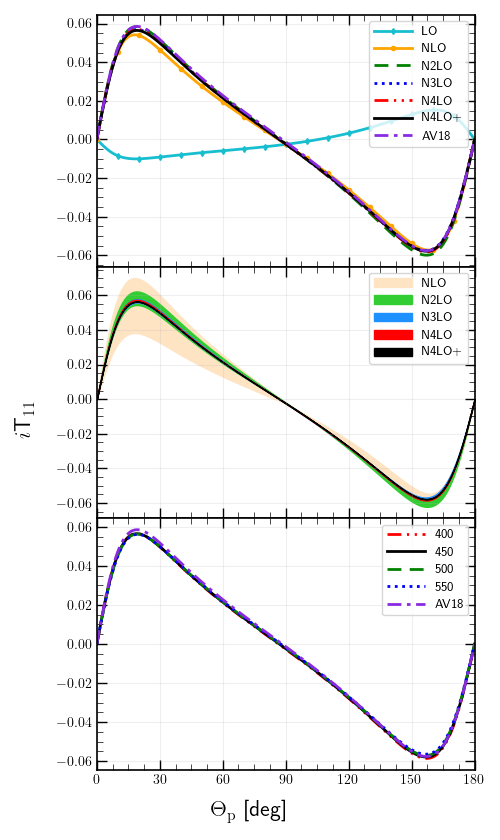

In [276]:
# for en in [100, 120]:
#     ax, fig = make_fig("AX2", en, 450, df_my, save=True, ylabel="$\Sigma_\gamma$")
ax, fig = make_fig("T11D2", 30, 450, df_my, save=True,
                   ylabel="$i$T$_{11}$")


# Assymetry

In [87]:
print(OBSERVABLES)


['CROSS', 'CROSS2', 'P1', 'P2', 'PHIP', 'WAVE', 'T11D', 'T20D', 'T21D', 'T22D', 'T11D2', 'T20D2', 'T21D2', 'T22D2', 'AX', 'AY', 'AZ', 'AX2', 'AY2', 'AZ2', 'POLNOUT(y)', 'POLNOUT2(y)', 'CROSSCAP', 'CROSSCAP2', 'AYN1CAP', 'AYN1CAP2', 'Energy']


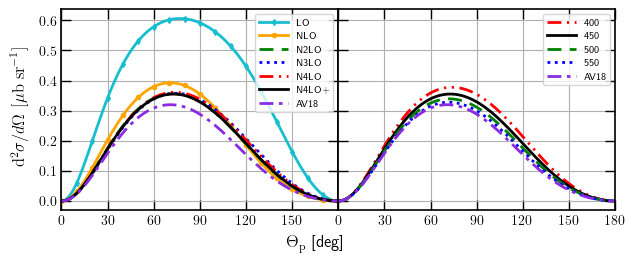

In [32]:
obs = "AX2"
ylabel = "$\mathrm{d}^2\sigma / d \Omega ~[\mu\mathrm{b~sr}^{-1}]$"
energy = 100

# fig, axes = plt.subplots(1,2, figsize=(6.5, 2.8))
fig = plt.figure(figsize=(6.5, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.08, size=12)
fig.supylabel(ylabel, x=0.03, y=0.6, size=12)
for force in FORCES:
    df_tmp = df_my[(df_my.FORCE == force) & (df_my.CUTOFF == 450) & (
        df_my.Energy == energy) & (df_my.WAVE == "SIEGERT")]
    axes[0].plot(df_tmp.angle, df_tmp[obs],
                 **line_styles[force], label=force)
for cutoff in CUTOFF:
    df_tmp = df_my[(df_my.FORCE == "N4LO+") & (df_my.CUTOFF == cutoff)
                   & (df_my.Energy == energy) & (df_my.WAVE == "SIEGERT")]
    axes[1].plot(df_tmp.angle, df_tmp[obs],
                 **ls_cutoff[cutoff], label=cutoff)
df_av18 = df_my[(df_my.FORCE == "AV18") & (df_my.Energy == energy)]
for j, ax in enumerate(axes):
    ax.plot(df_av18.angle, df_av18[obs],
            **line_styles["AV18"], label="AV18")
    # for i, fname in enumerate(df_exp[df_exp.energy == energy].fname.unique()):
    #     df_tmp = df_exp[(df_exp.energy == energy) & (df_exp.fname == fname)]
    #     ax.errorbar(df_tmp.angle, df_tmp.CROSS,
    #                 yerr=df_tmp.error, zorder=3, **exp_style[i], **marker_common)
    # style
    ax.legend(fontsize=7, handlelength=3)
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True)
    ax.set_xticks(np.arange(0, 180+j, 30))
    ax.set_xlim([0, 180])
    ax.grid()
fig.tight_layout()
# plt.savefig(f"Figures_De/{obs}_{energy}mev.pdf", dpi=600, facecolor="white")
plt.show()


# Binding

In [41]:
df_bind = pd.read_csv("./Deuteron/bind.txt", index_col=False,
                      delim_whitespace=True, names=["CUTNUM", "OSTAT", "BIND"])


In [46]:
df_gr = df_bind.groupby("OSTAT")["BIND"].agg(["mean", "std"])


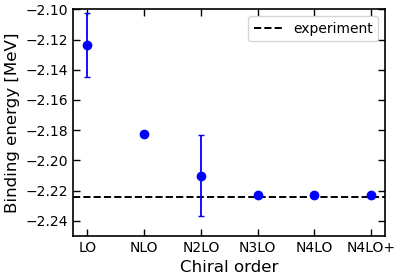

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.8), constrained_layout=True)
plt.xlabel("Chiral order", size=12)
plt.ylabel("Binding energy [MeV]", size=12)
# for i, en in enumerate([30, 100, 140]):
# df_tmp = df_bind[df_bind["CUTNUM"] == 2]
# ax.plot(df_tmp["OSTAT"], df_tmp["BIND"], "o",
#         color="blue", markersize=8, lw=1.5, zorder=2)
ax.errorbar(np.arange(6), df_gr["mean"], yerr=df_gr["std"],
                fmt="o", color="blue", markersize=6, elinewidth=1.3, capsize=2.5)
ax.axhline(-2.224564, c="k", ls="dashed", lw=1.4, zorder=1, label = "experiment")
plt.legend()
ax.tick_params(axis="y", which='minor', direction='in', length=4,
                    width=0.5, top=True, right=True)
ax.tick_params(axis='x', which='minor', bottom=False)
ax.tick_params(which='major', direction='in',
                    length=5, width=1, top=True, right=True)

# ax.set_title("E$_\gamma$ = {} MeV".format(en))
plt.setp(ax, xticks=np.arange(6), xticklabels=FORCES)
plt.ylim([-2.25, -2.1])

plt.savefig(f"Figures_De/Binding_energy.pdf",
            dpi=600, facecolor="white")
plt.show()
